In [2]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_2'
model_variant = 'base'

training_size = 15000
test_size = 5000

In [3]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import models
import os
import time
import tensorflow as tf
from keras import callbacks
pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [23]:
# SETUP MULTI CLASSIFICATION ENCODE/DECODE DICTS
polarity_classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

enc_pol = {
  0 : '0.0',
  1 : '-1.0',
  2 : '-0.9',
  3 : '-0.8',
  4 : '-0.7',
  5 : '-0.6',
  6 : '-0.5',
  7 : '-0.4',
  8 : '-0.3',
  9 : '-0.2',
  10 : '-0.1',
  11 : '0.1',
  12 : '0.2',
  13 : '0.3',
  14 : '0.4',
  15 : '0.5',
  16 : '0.6',
  17 : '0.7',
  18 : '0.8',
  19 : '0.9',
  20 : '1.0',
}

pol_enc = {
    0.0: 0,
    -1.0: 1,
    -0.9: 2,
    -0.8: 3,
    -0.7: 4,
    -0.6: 5,
    -0.5: 6,
    -0.4: 7,
    -0.3: 8,
    -0.2: 9,
    -0.1: 10,
    0.1: 11,
    0.2: 12,
    0.3: 13,
    0.4: 14,
    0.5: 15,
    0.6: 16,
    0.7: 17,
    0.8: 18,
    0.9: 19,
    1.0: 20,
}

# def encoded_to_polarity(sequence):
#     polarities = []
#     for v in sequence:
#         polarities.append(enc_pol[v])
#     return polarities

def encoded_to_polarity(list):
    polarities = []
    for seq in list:
        polarities.append([enc_pol[v] for v in seq])
    return polarities

In [5]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
15000 samples are taken from the head for training
5000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
14995,1982,s,s,PROPN,0.000000,M
14996,1982,billion,billion,NUM,0.000000,M
14997,1982,deal,deal,NOUN,-0.192667,M
14998,1982,buy,buy,VERB,-0.121307,M


In [6]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

def gender_seq_to_single(seqs):
    genders = []
    for seq in seqs:
        genders.append(seq[0])
    return genders

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])

train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_18608/2253757619.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_18608/2253757619.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
1666,1978,"[Outside, S, vis...","[outside, s, vis...","[ADP, NOUN, VERB...",[-0.050567109123...,F
1667,1979,"[Reuters, Mobile...","[Reuters, Mobile...","[PROPN, PROPN, P...",[-0.087097977562...,M
1668,1980,"[agreement, caps...","[agreement, cap,...","[NOUN, VERB, NOU...",[-0.070063994144...,M
1669,1981,[Inc],[Inc],[PROPN],[-0.015229293732...,M


In [7]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1911,"[denied, engagin...","[deny, engage, n...","[VERB, VERB, ADJ...",[-0.006808272697...,F
1,830,"[attendees, hear...","[attendee, heari...","[NOUN, NOUN, VER...","[0.0, 0.0, 0.256...",M
2,378,"[singer, came, f...","[singer, come, f...","[NOUN, VERB, NOU...",[0.0219273779142...,M
3,459,"[Riders, drivers...","[rider, driver, ...","[NOUN, NOUN, NOU...","[0.0, -0.1099246...",M
4,1570,"[people, team, d...","[people, team, d...","[NOUN, NOUN, ADJ...",[-0.422326553045...,M
...,...,...,...,...,...,...
1666,361,"[Chicago, White,...","[Chicago, White,...","[PROPN, PROPN, P...","[0.0, -0.0251788...",M
1667,402,"[week, great, tw...","[week, great, tw...","[NOUN, ADJ, NOUN...",[0.0037322095557...,F
1668,690,"[Uber, terms, se...","[uber, term, ser...","[ADJ, NOUN, NOUN...",[-0.041521220894...,M
1669,94,"[somebody, Jets,...","[somebody, Jets,...","[PRON, PROPN, VE...","[0.0, 0.0, -0.15...",M


<AxesSubplot:>

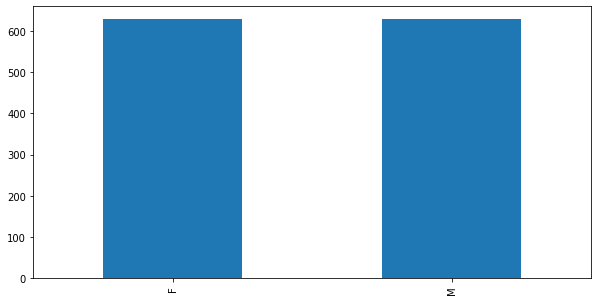

In [8]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
def equal_genders(data_):
    M, F = data_["Gender"].value_counts()
    if M>F:
        diff = M-F
        return data_.drop(data_.loc[data_['Gender'] == 'M'].index[:diff], axis=0)
    elif F>M:
        diff = F-M
        return data_.drop(data_.loc[data_['Gender'] == 'F'].index[:diff], axis=0)

train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [9]:
# DEFINE FUNCTION FOR PLOTTING SENTENCE LENGTHS
def plot_sentence_lengths(data_):
    sentence_plot = data_["Word"].values
    sentence_plot_sorted = list(sorted(sentence_plot, key=len))
    c = Counter(map(len, sentence_plot_sorted))

    total_sentences = 0
    total_words = 0
    for i in c:
        total_sentences = total_sentences + c[i]
        total_words = total_words + c[i]*i

    sentences_80_pct = total_sentences / 100 * 90
    words_80_pct = total_words / 100 * 90

    boundary_sen = 0
    counter_sen = 0

    for i in c:
        if(counter_sen + c[i] < int(sentences_80_pct)):
            counter_sen = counter_sen + c[i]
            boundary_sen = i
        else:
            break

    boundary_word = 0
    counter_word = 0

    for i in c:
        if(counter_word + c[i] * i < int(words_80_pct)):
            counter_word = counter_word + c[i] * i
            boundary_word = i
        else:
            break


    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


    plt.figure(figsize=[10,6])
    bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

    # for r in bars.get_children():
    #     if(r.get_x() > boundary_sen):
    #         r.set_alpha(0.2)

    plt.legend(loc="best")
    plt.ylim([0, max(list(c.values()))+10])
    ax2 = plt.gca()

    ymin, ymax = ax2.get_ylim()
    plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
    # plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

    plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
    plt.legend()
    plt.show()
    return boundary_sen

No handles with labels found to put in legend.


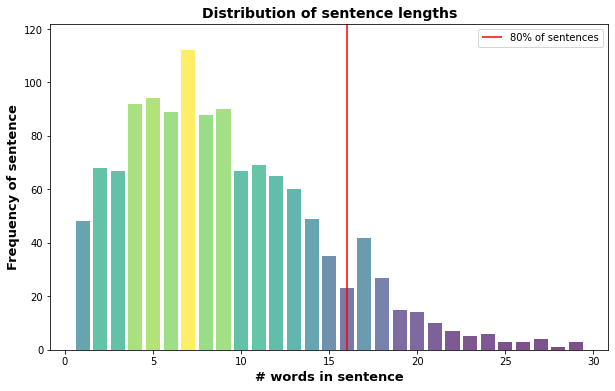

Decision boundary / 80 pct of sentence lengths is: 16


In [10]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [11]:
# ONE-HOT TARGET (POLARITY)
def round_polarities(polarities):
    pols_rounded = []
    for pol_seq in polarities:
        pols_rounded.append([0.0 if round(pol,1) == -0.0 else round(pol,1) for pol in pol_seq])
    return pols_rounded

def encode_polarities(polarities):
    # le = LabelEncoder()
    # le.classes_ = polarity_classes

    # pols_encoded = []
    # for pol_seq in polarities:
    #     pols_encoded.append(le.transform(pol_seq))

    pols_encoded = []
    for pol_seq in polarities:
        pols_encoded.append([pol_enc[pol] for pol in pol_seq])
    return pols_encoded

def one_hot_polarities(polarities):
    pols_one_hot = []
    for pol_seq in polarities:
        pols_one_hot.append([to_categorical(pol, 21) for pol in pol_seq])
    return pols_one_hot


train_pols_rounded = round_polarities(train_data['Polarity'])
test_pols_rounded = round_polarities(test_data['Polarity'])

train_pols_encoded = encode_polarities(train_pols_rounded)
y_test = encode_polarities(test_pols_rounded)

y_train = one_hot_polarities(train_pols_encoded)

print("Polarities:", polarity_classes)
print("Polarities encoded:", encode_polarities([polarity_classes]))
print("Example of one-hot encoded -0.5 polarity:", one_hot_polarities(encode_polarities([[-0.5]])))

Polarities: [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Polarities encoded: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
Example of one-hot encoded -0.5 polarity: [[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)]]


In [12]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
def encode_feature(train_data_, test_data_):
    tokenizer = Tokenizer()
    # ONLY FIT ON TRAIN DATA
    tokenizer.fit_on_texts(train_data_)
    return tokenizer.texts_to_sequences(train_data_), tokenizer.texts_to_sequences(test_data_), len(tokenizer.word_index)

train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])


trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [13]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

# root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_log_dir = get_run_logdir()
# file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
# file_writer.set_as_default()

# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# my_callbacks = [earlystopping, tensorboard_cb]
my_callbacks = [earlystopping]


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 128)           381184    
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 256)           263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 128)           164352    
_________________________________________________________________
time_distributed (TimeDistri (None, 16, 21)            2709      
Total params: 811,413
Trainable params: 811,413
Non-trainable params: 0
_________________________________________________________________


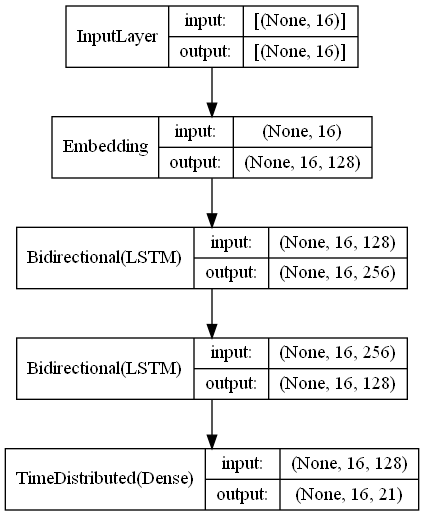

In [14]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len, mask_zero=True),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
    layers.TimeDistributed(layers.Dense(21, activation="softmax"))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [15]:
# FITTING MODEL

history = model.fit(X_train, y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
32/32 [==============================] - 16s 157ms/step - loss: 1.2403 - accuracy: 0.5102 - val_loss: 0.8913 - val_accuracy: 0.5263
Epoch 2/20
32/32 [==============================] - 3s 83ms/step - loss: 0.8401 - accuracy: 0.5305 - val_loss: 0.7931 - val_accuracy: 0.5268
Epoch 3/20
32/32 [==============================] - 3s 84ms/step - loss: 0.8052 - accuracy: 0.5305 - val_loss: 0.7795 - val_accuracy: 0.5268
Epoch 4/20
32/32 [==============================] - 3s 88ms/step - loss: 0.7932 - accuracy: 0.5305 - val_loss: 0.7677 - val_accuracy: 0.5268
Epoch 5/20
32/32 [==============================] - 3s 91ms/step - loss: 0.7662 - accuracy: 0.5411 - val_loss: 0.7170 - val_accuracy: 0.5823
Epoch 6/20
32/32 [==============================] - 3s 80ms/step - loss: 0.6351 - accuracy: 0.6753 - val_loss: 0.5140 - val_accuracy: 0.7368
Epoch 7/20
32/32 [==============================] - 3s 81ms/step - loss: 0.4198 - accuracy: 0.7721 - val_loss: 0.3692 - val_accuracy: 0.7981
Epoch 8/20


red is training, blue is validation


<Figure size 432x288 with 0 Axes>

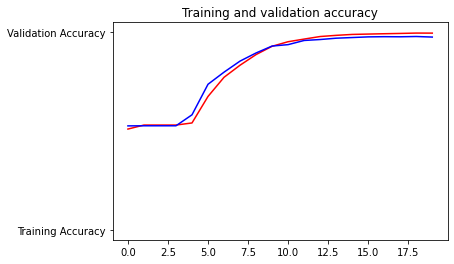

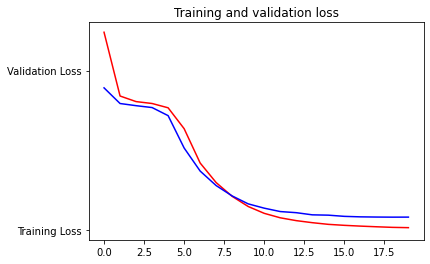

<Figure size 432x288 with 0 Axes>

In [16]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [17]:
# SAVING MODEL
# model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

In [18]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred

array([[10,  0, 13, ...,  0,  0,  0],
       [11, 12,  0, ...,  0,  0,  0],
       [11, 10, 11, ...,  0,  0,  0],
       ...,
       [10,  8,  7, ...,  0,  0,  0],
       [10,  0, 10, ...,  0,  0,  0],
       [ 9, 10, 10, ...,  0,  0,  0]], dtype=int64)

In [405]:
# TRANSFORM TARGET ENCODED TO POLARITY
# y_pred = np.array(encoded_to_polarity(y_pred))
# y_test = np.array(encoded_to_polarity(y_test))

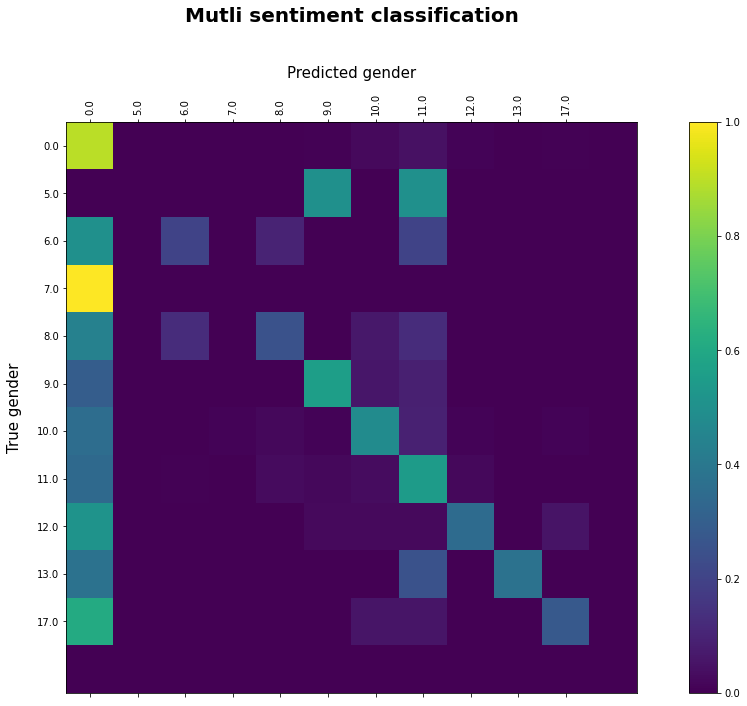

In [21]:
# PLOTTING CONFUSION MATRIX
cm_true = y_test.flatten()
cm_pred = y_pred.flatten()

cm = confusion_matrix(cm_true, cm_pred, normalize='true')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Mutli sentiment classification',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []
for x in np.unique(np.array(cm_pred)):
    cm_axis_vals.append(float(x))
cm_axis_vals.sort()

number_of_unique_pols = len(cm_axis_vals)

fig.colorbar(cax)
plt.xticks(range(number_of_unique_pols), cm_axis_vals, rotation=90)
plt.yticks(range(number_of_unique_pols), cm_axis_vals)
plt.show()

In [407]:
# PRINTING METRICS
from sklearn.metrics import classification_report

report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:number_of_unique_pols]
df_perf_2.insert(loc=0, column='Polarity', value=cm_axis_vals)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarni

,Polarity,precision,recall,f1-score,support
0,-0.9,0.64,0.67,0.65,2370.0
1,-0.7,0.62,0.64,0.63,938.0
2,-0.6,0.66,0.71,0.68,291.0
3,-0.5,0.71,0.73,0.72,85.0
4,-0.4,0.47,0.49,0.48,53.0
5,-0.3,0.60,0.62,0.61,69.0
6,-0.2,0.55,0.50,0.52,12.0
7,-0.1,0.60,0.60,0.60,10.0
8,0.0,0.94,0.94,0.94,28768.0
9,0.1,0.62,0.60,0.61,1259.0


In [411]:
# # DEFINE XAI FUNCTION
# %reload_ext autoreload
# %autoreload 2
# from classes.data_prepper import DataPrepper

# # Borrowed from: https://www.geeksforgeeks.org/python-program-to-find-n-largest-elements-from-a-list/
# # Function returns N largest elements
# def Nmaxelements(list, N):
#     return list[:N]

# def find_complete_sentence(sentence_number, sentences):
#     index = sentences.index[sentences['Sentence #'] == sentence_number].tolist()[0]
#     return sentences['Text'][index]

# # Equation 8
# def p_s(polarities):
#     count = sum(map(lambda x: x > 0.0 or x < 0.0, polarities))
#     return sum(polarities) / count
    

# def XAI(predictions, input_data, N_greatest_polarities):
#     p = DataPrepper()
#     complete_sentences = pd.read_json('../datasets/7_sentences.json')

#     for pred_seq, row in zip(predictions, input_data.iterrows()):
#         data = row[1]

#         pred_seq = [float(v) for v in pred_seq]
#         sentiment = p_s(pred_seq)

#         if (sentiment > 0.1 or sentiment < -0.1):
#             print("\n---------------------------------------------------------------------------------------")
#             print("The sentence:", '"'+find_complete_sentence(data['Sentence #'], complete_sentences)+'".\n')
#             print("Was predicted to be", 'masculine' if sentiment < 0.0 else 'feminine', "("+str(sentiment)+").\n")

#             print("Most", 'masculine' if sentiment < 0 else 'feminine', "words in sentence are:\n")
#             greatest_pols = []

#             if (sentiment < 0):
#                 greatest_pols = Nmaxelements(sorted(pred_seq), N_greatest_polarities)
#             else:
#                 greatest_pols = Nmaxelements(sorted(pred_seq, reverse=True), N_greatest_polarities)

#             index = test_data.index[test_data['Sentence #'] == data["Sentence #"]].tolist()[0]
#             print("test_data", test_data['Word'][index])
#             print("data:", data["Word"])
#             print("len of words", len(data["Word"]), "len of pol_seq", len(pred_seq))
#             for pol in greatest_pols:
#                 i = pred_seq.index(pol)
#                 print("index:", i, "pred_seq:", pred_seq, "pol", pol)
#                 print("'"+data["Word"][i]+"'", "with a polarity of", round(pol,2))
        

In [412]:
# USE XAI ON PREDICTIONS
# XAI(y_pred[:100], test_data, 2)

constructor of DataPrepper

---------------------------------------------------------------------------------------
The sentence: "The Colombian star took it in stride, unsurprisingly, as the occasional sheer wardrobe malfunction is nothing new -- the star had a more embarrassing reveal in a pair of too-sheer leggings back in December.".

Was predicted to be masculine (-0.13333333333333333).

Most masculine words in sentence are:

test_data ['Colombian', 'star', 'took', 'stride', 'unsurprisingly', 'occasional', 'sheer', 'wardrobe', 'malfunction', 'new', 'star', 'embarrassing', 'reveal', 'pair', 'sheer', 'leggings']
data: ['Colombian', 'star', 'took', 'stride', 'unsurprisingly', 'occasional', 'sheer', 'wardrobe', 'malfunction', 'new', 'star', 'embarrassing', 'reveal', 'pair', 'sheer', 'leggings']
len of words 16 len of pol_seq 15
index: 6 pred_seq: [0.0, -0.2, 0.0, 0.0, 0.0, 0.0, -0.3, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0] pol -0.3
'sheer' with a polarity of -0.3
index: 1 pred_seq: [0

ZeroDivisionError: float division by zero